In [1]:
#import deleteResults
#import postProcessing

In [2]:
import numpy

import analysis
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


In [3]:
from analysisCounter import AnalysisCounter

counter_dict = analysis.get_counters()
rank_list = list(filter((-1).__ne__, analysis.get_rank_list()))
rank_table = pd.DataFrame(rank_list, columns=['Rank'])

In order to figure out appropriate buckets to sort results according to rank,
we display the total list of successfully ranked websites in a histogram
with relatively narrow buckets.

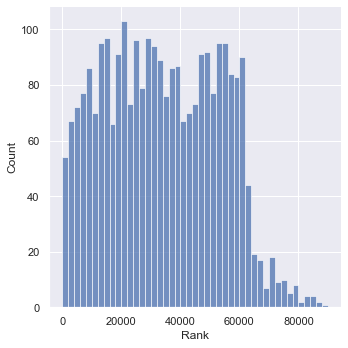

In [4]:
# Distribution of ranks in buckets of width=2000.
# This shows ranks > 60000 are underrepresented in dataset
sns.set_theme()
sns.displot(rank_table, x='Rank', binwidth=2000)
plt.savefig("plots/displot-rankdistribution.png", bbox_inches='tight', dpi=600)

From this graph we can see there is a drop-off roughly after 60000.
Because of this we only examine links up to that rank
in the graphs that divide results by rank.

In [5]:
def get_top_table(counter: AnalysisCounter, n: int = 10, index_name: str = 'index'):
    """
    Given a counter, return a LaTeX table of the first n entries.
    """
    counter_df = pd.DataFrame.from_dict(counter.total, orient='index', columns=['Count'])
    counter_df.index.name = index_name
    counter_data = counter_df.nlargest(n=n, columns=['Count'])
    return counter_data.to_latex()

In [6]:
def get_bucket_size_table(counter: AnalysisCounter, latex = False):
    """
    Given a counter, return a table of the rank-bucket sizes.
    """
    output = ''

    prefix = '\\begin{tabular}{lr}\n\\toprule\n' if latex else ''
    table_title = 'Bucket &  Count \\\\ \n\\midrule\n' if latex else ''
    line_divider = '\t&' if latex else ''
    line_end = '\\\\ \n' if latex else '\n'
    suffix = '\\bottomrule\n\\end{tabular}' if latex else ''

    output += prefix
    output += table_title
    for rank_bucket in counter.rank_buckets.keys():
        output += f'\t{rank_bucket}:{line_divider} \t{counter.rank_entries[rank_bucket]} {line_end}'
    output += suffix

    return output

In [7]:
def get_rank_plot(counter: AnalysisCounter, n: int = 10, index_name: str = 'index'):
    """
    Given a counter, return a rank-categorisation plot of the first n entries.
    """
    counter_df = pd.DataFrame(counter.rank)
    counter_df.insert(0, 'Total', 0)
    for key in counter.total.keys():
        try:
            counter_df.at[key, 'Total'] = counter.total[key]
        except KeyError:
            continue

    bucket_cols = list(domain_counter.rank_buckets.keys())
    for bucket in bucket_cols:
        counter_df[bucket] = counter_df[bucket].div(counter.rank_entries[bucket], axis=0).multiply(100)
    counter_df['Total'] = counter_df['Total'].div(counter.total_entries, axis=0).multiply(100)

    counter_data = counter_df.nlargest(n=n, columns=['Total'])[bucket_cols]
    counter_data.index.name = index_name
    counter_data.reset_index(inplace=True)

    counter_data_long = counter_data.melt(id_vars=index_name, var_name='rank', value_name='percentage')
    return sns.catplot(data=counter_data_long, kind='swarm', x='rank', y='percentage', hue=index_name)

In [8]:
def get_cmp_plot(counter: AnalysisCounter, n: int = 10, index_name: str = 'index'):
    """
    Given a counter, return a CMP-categorisation plot of the first n entries.
    """
    counter_df = pd.DataFrame(counter.consent)
    counter_df.insert(0, 'Total', 0)
    for key in counter.total.keys():
        try:
            counter_df.at[key, 'Total'] = counter.total[key]
        except KeyError:
            continue

    counter_df['cmp'] = counter_df['cmp'].div(counter.cmp_entries, axis=0).multiply(100)
    counter_df['no-cmp'] = counter_df['no-cmp'].div(counter.no_cmp_entries, axis=0).multiply(100)
    counter_df['Total'] = counter_df['Total'].div(counter.total_entries, axis=0).multiply(100)

    counter_data = counter_df.nlargest(n=n, columns=['Total'])
    del counter_data['Total']
    counter_data.index.name = index_name
    counter_data.reset_index(inplace=True)
    counter_data_long = counter_data.melt(id_vars=index_name, var_name='consent', value_name='percentage')
    plot = sns.catplot(data=counter_data_long, kind='bar', x=index_name, y='percentage', hue='consent')
    new_label = [f'cmp\nn={counter.cmp_entries}', f'no-cmp\nn={counter.no_cmp_entries}']
    for t, l in zip(plot.legend.texts, new_label):
        t.set_text(l)
    return plot


In [9]:
domain_counter = counter_dict['domain']
usage_counter = counter_dict['usage']
amount_counter = counter_dict['total']
organisation_counter = counter_dict['organisation']
cmp_counter = counter_dict['cmp']
endpoint_counters = counter_dict['endpoints']
sns.set_theme()

## Amount of leakages per crawled website

The following text covers the total number of pages that
circumvent a strict referrer policy at least once.

Total number of crawled websites:
	3172
Total number of websites with at least 1 circumvention: 
	2958

\begin{tabular}{lr}
\toprule
{} &  Count \\
amount &        \\
\midrule
≥ 1    &   2958 \\
≥ 2    &   2746 \\
≥ 3    &   2518 \\
≥ 4    &   2302 \\
≥ 5    &   2099 \\
≥ 6    &   1905 \\
≥ 7    &   1703 \\
≥ 8    &   1527 \\
≥ 9    &   1372 \\
≥ 10   &   1228 \\
\bottomrule
\end{tabular}

Total nr of websites split by rank:
	1-12000: 	425
	12001-24000: 	524
	24001-36000: 	532
	36001-48000: 	475
	48001-60000: 	526

Split by CMP:
	CMP:	485
	No CMP:	2687


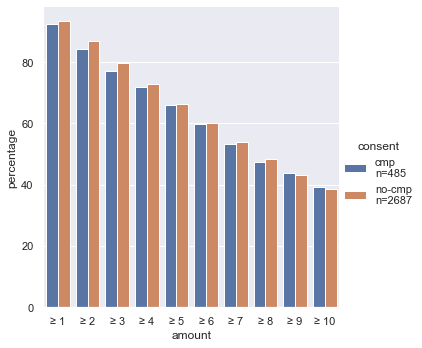

In [10]:
print(f'Total number of crawled websites:\n\t{amount_counter.total_entries}')
print(f'Total number of websites with at least 1 circumvention: \n\t{amount_counter.total["≥ 1"]}\n')
print(get_top_table(amount_counter, index_name='amount'))


print(f'Total nr of websites split by rank:')
for bucket in amount_counter.rank_buckets.keys():
    print(f'\t{bucket}: \t{amount_counter.rank_entries[bucket]}')
print(f'\nSplit by CMP:')
print(f'\tCMP:\t{amount_counter.cmp_entries}')
print(f'\tNo CMP:\t{amount_counter.no_cmp_entries}')
amount_cmp_plot = get_cmp_plot(amount_counter,n=10,index_name='amount')
plt.savefig("plots/catplot-amount_cmp.png", bbox_inches='tight', dpi=600)

\begin{tabular}{lr}
\toprule
Bucket &  Count \\ 
\midrule
	1-12000:	& 	425 \\ 
	12001-24000:	& 	524 \\ 
	24001-36000:	& 	532 \\ 
	36001-48000:	& 	475 \\ 
	48001-60000:	& 	526 \\ 
\bottomrule
\end{tabular}


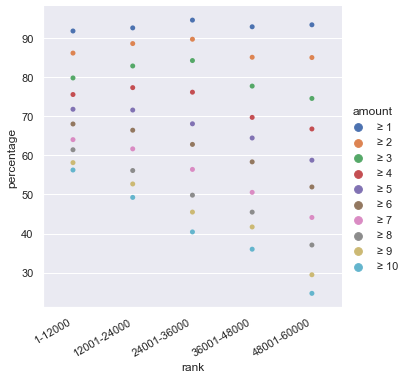

In [11]:
print(get_bucket_size_table(counter=amount_counter, latex=True))
amount_rank_plot = get_rank_plot(amount_counter, index_name='amount')
_ = plt.xticks(rotation=30, ha='right')
plt.savefig("plots/catplot-amount_rank.png", bbox_inches='tight', dpi=600)

## Domains being leaked to
The following graphs and text consider the domains to which URLs get leaked.
The data only considers cases where a strict referrer policy is circumvented.

In [12]:
print(f'Total number of websites being leaked from: \t{domain_counter.total_entries}\n'
      f'Total number of domains being leaked to: \t{len(domain_counter.total)}\n')

table_size=10
print(f'LaTeX table displaying the top {table_size} domains being leaked to:')
print(get_top_table(domain_counter, n=table_size, index_name='Domains'))

Total number of websites being leaked from: 	2958
Total number of domains being leaked to: 	1087

LaTeX table displaying the top 10 domains being leaked to:
\begin{tabular}{lr}
\toprule
{} &  Count \\
Domains               &        \\
\midrule
google-analytics.com  &   2541 \\
facebook.com          &   1698 \\
doubleclick.net       &   1537 \\
google.com            &   1452 \\
google.nl             &   1317 \\
bing.com              &    871 \\
pinterest.com         &    608 \\
nr-data.net           &    376 \\
twitter.com           &    308 \\
googlesyndication.com &    271 \\
\bottomrule
\end{tabular}



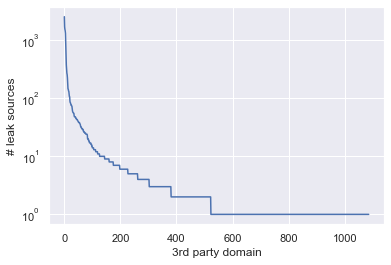

In [13]:
domain_df = pd.DataFrame.from_dict(data=domain_counter.total, orient='index', columns=['# leak sources'])
domain_df.sort_values(inplace=True, ascending=False, by='# leak sources')
domain_df.reset_index(inplace=True)
del domain_df['index']
domain_df.index.name = '3rd party domain'
g = sns.lineplot(data=domain_df, y='# leak sources', x='3rd party domain')
g.set(yscale='log')
#_ = plt.axis([0,400,0,75])
# TODO: use log scale
# "x% of leakages go o y% of domains"

plt.savefig("plots/relplot-LeaksPer3rdParty.png", bbox_inches='tight', dpi=600)

In this plot we see a sorted list of all domains being leaked to.
The list is sorted by the number of websites leaking to each domain.

Out of 1087 domains we see that:</br>
less than 375 domains get leaked to more than twice.</br>
roughly 125 domains get leaked to more than 10 times.

Rank bucket sizes:
\begin{tabular}{lr}
\toprule
Bucket &  Count \\ 
\midrule
	1-12000:	& 	390 \\ 
	12001-24000:	& 	485 \\ 
	24001-36000:	& 	503 \\ 
	36001-48000:	& 	441 \\ 
	48001-60000:	& 	491 \\ 
\bottomrule
\end{tabular}


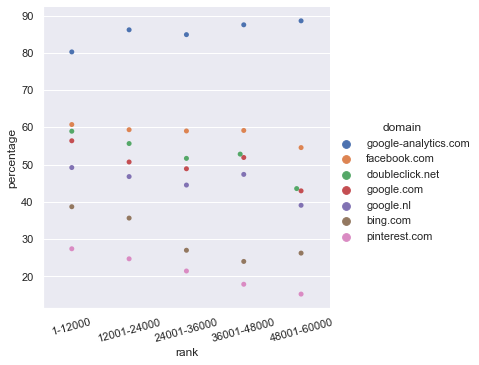

In [14]:
domain_rank_plot = get_rank_plot(domain_counter, n=7, index_name='domain')
_ = plt.xticks(rotation=15)
plt.savefig("plots/catplot-domain_rank.png", bbox_inches='tight', dpi=600)
print('Rank bucket sizes:')
print(get_bucket_size_table(domain_counter, latex=True))

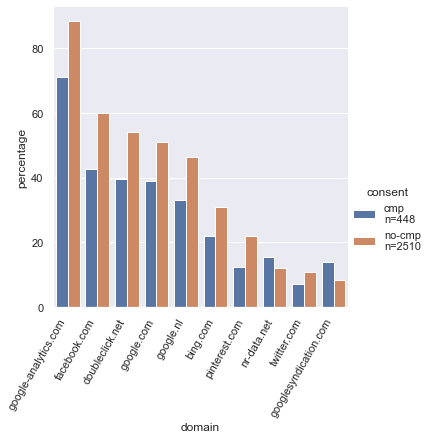

In [15]:
domain_cmp_plot = get_cmp_plot(domain_counter, index_name='domain')
_ = plt.xticks(rotation=60, ha='right')
plt.savefig("plots/catplot-domain_cmp.png", bbox_inches='tight', dpi=600)

## Organisations

The following text and graphs show the leakages to specific organisations,
which may own multiple domains.

For example leakages to ```google-analytics.com``` and ```doubleclick.net```
are both considered leakages to Google LLC.

In [16]:
print(f'Total number of known organisations being leaked to:\t {len(organisation_counter.total)}\n'
      f'Number of websites leaking to these organisations:\t {organisation_counter.total_entries}')

table_size=10
print(f'LaTeX table displaying the top {table_size} organisations being leaked to:')
print(get_top_table(organisation_counter, n=table_size, index_name='Organisations'))

Total number of known organisations being leaked to:	 425
Number of websites leaking to these organisations:	 2936
LaTeX table displaying the top 10 organisations being leaked to:
\begin{tabular}{lr}
\toprule
{} &  Count \\
Organisations         &        \\
\midrule
Google LLC            &   2700 \\
Facebook, Inc.        &   1698 \\
Microsoft Corporation &    940 \\
Pinterest, Inc.       &    608 \\
New Relic             &    376 \\
Twitter, Inc.         &    309 \\
Trustpilot A/S        &    224 \\
Salesforce.com, Inc.  &    161 \\
PayPal, Inc.          &    135 \\
Cybot ApS             &    131 \\
\bottomrule
\end{tabular}



Rank bucket sizes:
	1-12000: 	385 
	12001-24000: 	483 
	24001-36000: 	498 
	36001-48000: 	438 
	48001-60000: 	488 



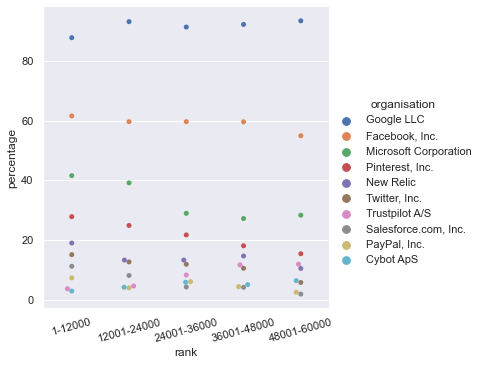

In [17]:
organisation_rank_plot = get_rank_plot(organisation_counter, n=10, index_name='organisation')
_ = plt.xticks(rotation=15)
plt.savefig("plots/catplot-org_rank.png", bbox_inches='tight', dpi=600)

print('Rank bucket sizes:')
print(get_bucket_size_table(organisation_counter))

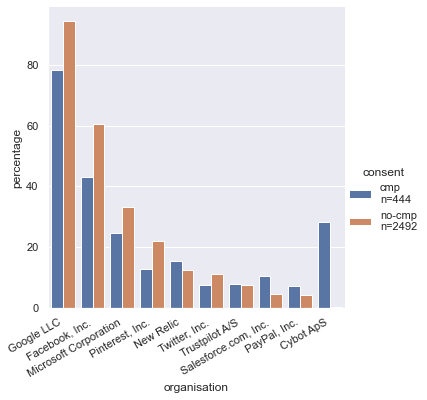

In [18]:
organisation_cmp_plot = get_cmp_plot(organisation_counter, index_name='organisation')
_ = plt.xticks(rotation=30, ha='right')
plt.savefig("plots/catplot-org_cmp.png", bbox_inches='tight', dpi=600)

## CMP
The following cell concerns leakages to specific CMPs.

Total number of sites using a cmp: 485

\begin{tabular}{lr}
\toprule
{} &  Amount \\
\midrule
onetrust-LI       &     210 \\
cookiebot         &     127 \\
onetrust-OLD      &      40 \\
cookiebar         &      26 \\
optanon           &      20 \\
trustarcbar       &      17 \\
cookieinformation &      11 \\
didomi.io         &      10 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
Bucket &  Count \\ 
\midrule
	1-12000:	& 	91 \\ 
	12001-24000:	& 	104 \\ 
	24001-36000:	& 	102 \\ 
	36001-48000:	& 	59 \\ 
	48001-60000:	& 	60 \\ 
\bottomrule
\end{tabular}


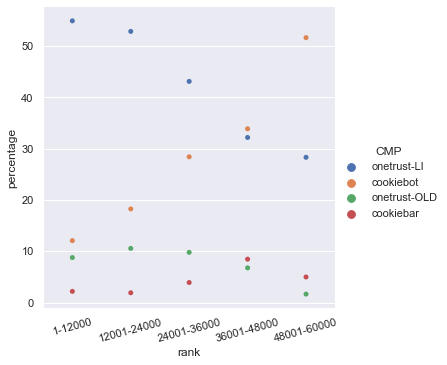

In [19]:
cmp_df = pd.DataFrame.from_dict(cmp_counter.total, orient='index', columns=['Amount'])
cmp_df.sort_values(inplace=True, ascending=False, by='Amount')
cmp_rank_plot = get_rank_plot(cmp_counter, n=4, index_name='CMP')
_ = plt.xticks(rotation=15)
plt.savefig("plots/catplot-cmp_rank.png", bbox_inches='tight', dpi=600)

print(f"Total number of sites using a cmp: {cmp_counter.total_entries}\n")

print(cmp_df.nlargest(n=8, columns=['Amount']).to_latex())
print(get_bucket_size_table(counter=cmp_counter, latex=True))


## Endpoint leakages

The following cells concern the leakages to specific endpoints.

In [20]:
for endpoint_counter in endpoint_counters.values():
    print(get_top_table(endpoint_counter, n=5, index_name='page'))

\begin{tabular}{lr}
\toprule
{} &  Count \\
page                                 &        \\
\midrule
google-analytics.com/j/collect       &   1843 \\
google-analytics.com/collect         &   1769 \\
google-analytics.com/g/collect       &    607 \\
google-analytics.com/r/collect       &      8 \\
ssl.google-analytics.com/r/\_\_utm.gif &      5 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  Count \\
page                                    &        \\
\midrule
facebook.com/tr/                        &   1619 \\
facebook.com/x/oauth/status             &    114 \\
facebook.com/plugins/like.php           &     46 \\
graph.facebook.com/                     &     17 \\
facebook.com/plugins/customer\_chat/SDK/ &     13 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  Count \\
page                                       &        \\
\midrule
googleads.g.doubleclick.net/pagead/ads     &    166 \\
securepubads.g.doubleclick.net/gampad/ads  &    114 \\
googleads.g.d

## Additional data
The following cells display additional tables with data.

In [21]:
# Create top 40 most leaked-to domains table, including rank bucket division
rank_df = pd.DataFrame(domain_counter.rank)
rank_df.insert(0, 'Total', 0)
for key in domain_counter.total.keys():
    try:
        rank_df.at[key, 'Total'] = domain_counter.total[key]
    except KeyError:
        continue
column_selection = ['Total'] + list(domain_counter.rank_buckets.keys())
rank_data = rank_df.nlargest(n=40, columns=['Total'])[column_selection]
rank_data[column_selection] = rank_data[column_selection].fillna(0)
rank_data[column_selection] = rank_data[column_selection].astype(int)
print(rank_data.to_latex())
print(amount_counter.total_entries)
print(amount_counter.rank_entries)

\begin{tabular}{lrrrrrr}
\toprule
{} &  Total &  1-12000 &  12001-24000 &  24001-36000 &  36001-48000 &  48001-60000 \\
\midrule
google-analytics.com       &   2541 &      313 &          418 &          427 &          386 &          435 \\
facebook.com               &   1698 &      237 &          288 &          297 &          261 &          268 \\
doubleclick.net            &   1537 &      230 &          270 &          260 &          233 &          214 \\
google.com                 &   1452 &      220 &          246 &          246 &          229 &          211 \\
google.nl                  &   1317 &      192 &          227 &          224 &          209 &          192 \\
bing.com                   &    871 &      151 &          173 &          136 &          106 &          129 \\
pinterest.com              &    608 &      107 &          120 &          108 &           79 &           75 \\
nr-data.net                &    376 &       73 &           64 &           66 &           64 &        

In [22]:
# Create top 10 most leaked-to domains table, including both absolute and
# relative amounts, and relative usage amounts

leak_use_df = pd.DataFrame.from_dict(domain_counter.total, orient='index', columns=['Amount leaking'])
leak_use_df.index.name = 'Domain'
# leak_use_df = leak_use_df.nlargest(n=30, columns=['Amount leaking'])
leak_use_df.insert(len(leak_use_df.columns), 'Amount using', 0)
for index in leak_use_df.index:
    try:
        leak_use_df.at[index, 'Amount using'] = usage_counter.total[index]
    except KeyError:
        leak_use_df.at[index, 'Amount using'] = 0

leak_use_df.sort_values(by='Amount leaking',inplace=True, ascending=False)
leak_use_df['%'] = round(leak_use_df['Amount leaking']/leak_use_df['Amount using']*100,1)
print('Domains being leaked to, including the amount of distinct websites')
print('leaking to them, the amount of distinct websites sending at least one')
print('request to the domain and the percentage of usages that also include a leakage,')
print('sorted by most leaked-to domains.')
print(leak_use_df.head(10).to_latex())

alt_results_df = leak_use_df[(leak_use_df['Amount leaking'] >= 40) &
                (leak_use_df['Amount leaking']*2 <= leak_use_df['Amount using'])].copy()


alt_results_df['abs_dif'] = (alt_results_df['Amount leaking'] - alt_results_df['Amount using']).abs()
alt_results_df.sort_values(by='abs_dif', inplace=True, ascending=False)
alt_results_df.drop(columns='abs_dif', inplace=True)
latex = alt_results_df.head(10).sort_values(by='Amount leaking', ascending=False).to_latex()
# numbers = sorted(re.findall('[0-9]+', latex), key=lambda x: int(x))
# for number in numbers:
#     replace_string = f'{number}\\\\ {round(int(number)/amount_counter.total_entries * 100,1)}'
#     replace_string = '\\begin{tabular}{@{}c@{}}' + replace_string + '\\%\end{tabular}'
#     latex = latex.replace(f' {number} ', f' {replace_string} ')
print('Domains being leaked to, including the amount of distinct websites leaking to them,')
print('the amount of distinct websites sending at least one request to the domain')
print('and the percentage of usages that also include a leakage, ')
print('filtered to percentages <50 and leakage amounts >40, sorted by usage amount')
print(latex)



Domains being leaked to, including the amount of distinct websites
leaking to them, the amount of distinct websites sending at least one
request to the domain and the percentage of usages that also include a leakage,
sorted by most leaked-to domains.
\begin{tabular}{lrrr}
\toprule
{} &  Amount leaking &  Amount using &     \% \\
Domain                &                 &               &       \\
\midrule
google-analytics.com  &            2541 &          2713 &  93.7 \\
facebook.com          &            1698 &          1772 &  95.8 \\
doubleclick.net       &            1537 &          2597 &  59.2 \\
google.com            &            1452 &          2606 &  55.7 \\
google.nl             &            1317 &          2222 &  59.3 \\
bing.com              &             871 &           923 &  94.4 \\
pinterest.com         &             608 &           643 &  94.6 \\
nr-data.net           &             376 &           422 &  89.1 \\
twitter.com           &             308 &           380 &